In [1]:
from lib import cnn_tester
import sys
sys.path.insert(0, '../src')
from lib import datasets

from os.path import join as opj
import pandas as pd
import numpy as np
import torch
import os
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

# Hyperparameters validation - Computation of performance

In [2]:
# Directories
data_dir = '../data/preprocessed/BrainPedia_dataset'
out_dir = '../data/derived/BrainPedia_dataset'

In [3]:
# Specific setup
preprocess_type = 'resampled_masked_normalized'

# Training setup 
train_subset ='bp_dataset'
lr_to_test = ['1e-04']
model_to_test = ['model_cnn_4layers', 'model_cnn_5layers']
init_to_test = ['retrain_no', 'retrain_all']
batch_to_test = [32, 64]
epochs_to_test = ['epochs_200', 'epochs_500']

In [4]:
accuracies = []
f1_list = []
model_list = []
arch_list = []
epochs_list = []
batch_list = []
lr_list = []
prec_list = []
rec_list = []

if not os.path.exists('../figures/validation_model_bp.csv'):
    print('Calculating validation performance...')
    for model in model_to_test:
        for init in init_to_test:
            for epochs in epochs_to_test:
                for batch in batch_to_test:
                    for lr in lr_to_test:
                        for i in range(5):
                            model_list.append(init)
                            arch_list.append(model)
                            batch_list.append(batch)
                            epochs_list.append(epochs)
                            lr_list.append(lr)
                            test_id_file = opj(data_dir, f'test_hp_bp_dataset_fold_{i}.txt')
                            label_file = opj(data_dir, f'bp_dataset_labels.csv')
                            label_col = 'tags'
                            label_filelist = pd.read_csv(opj('../data/preprocessed/BrainPedia_dataset', 
                                                         f'bp_dataset_labels.csv'))

                            label_list = sorted(np.unique(label_filelist['tags']))

                            test_set = datasets.ClassifDataset(opj(data_dir, preprocess_type), test_id_file, label_file, label_col,
                                                              label_list)

                            # Model to test
                            parameter_file = opj(out_dir, f"{train_subset}_maps_classification_tags_{model}_" + \
                                    f"valid_hp_{init}_{preprocess_type}_epochs_1000_batch_size_{batch}_lr_{lr}", 
                                             f"model_{epochs}_fold_{i}.pt")

                            acc, f1, prec, rec, acc_class = cnn_tester.tester(test_set, 
                                                                              parameter_file) # Compute results

                            accuracies.append(acc)
                            f1_list.append(f1)
                            prec_list.append(prec)
                            rec_list.append(rec)
                    
    # Creation of dataframe with results
    init_list = ['Default algorithm' if i == 'retrain_no' else 'Pre-trained CAE' for i in model_list]

    arch_list = ['5 layers' if i == 'model_cnn_5layers' else '4 layers' for i in arch_list]

    df = pd.DataFrame()
    df['Accuracy']=accuracies
    df['F1']=f1_list
    df['Initialization']=init_list
    df['Batch']=batch_list
    df['Epochs']=epochs_list
    df['Architecture']=arch_list
    df['Learning rate']=lr_list
    df['Precision']=prec_list
    df['Recall']=rec_list
    
    df.to_csv('../figures/validation_model_bp.csv') 

else:
    print('Performance already computed.')

Performance already computed.


# Hyperparameter validation - Exploration of results

### Table 3 - Hyperparameters chosen for each dataset and corresponding performance of the classifier on the validation set of the dataset 

Here, we computed the results of Table 3 for BrainPedia dataset.

In [5]:
df = pd.read_csv('../figures/validation_model_bp.csv') 
lr_to_test = [1e-04]
df_mean = pd.DataFrame(columns=['Initialization', 'Batch', 'Epochs', 'Learning rate', 'Architecture','Accuracy', 'F1'])
for init in ['Default algorithm', 'Pre-trained CAE']:
    for model in ['4 layers', '5 layers']:
        for batch in batch_to_test:
            for epochs in epochs_to_test:
                for lr in lr_to_test:
                    df_mean = df_mean.append({'Initialization':init, 'Batch':batch, 'Epochs':epochs, 'Learning rate':lr, 'Architecture':model, 
                              'Accuracy': np.std(df['Accuracy'][df['Architecture']==model][df['Initialization']==init][df['Epochs']==epochs][df['Batch']==batch][df['Learning rate']==lr]), 
                              'F1': np.std(df['F1'][df['Architecture']==model][df['Initialization']==init][df['Epochs']==epochs][df['Batch']==batch][df['Learning rate']==lr])}, 
                             ignore_index=True)

In [6]:
df_mean[df_mean['Initialization']=='Default algorithm'].nlargest(1, ['Accuracy', 'F1'])

,Initialization,Batch,Epochs,Learning rate,Architecture,Accuracy,F1
3,Default algorithm,64,epochs_500,0.0001,4 layers,0.298903,0.299818


In [7]:
df_mean[df_mean['Initialization']=='Pre-trained CAE'].nlargest(1, ['Accuracy', 'F1'])

,Initialization,Batch,Epochs,Learning rate,Architecture,Accuracy,F1
11,Pre-trained CAE,64,epochs_500,0.0001,4 layers,0.243754,0.229068


# Test models with cross-validation

## Small BrainPedia

In [8]:
if not os.path.exists('../figures/comparison_small_bp.csv'):
    accuracies = []
    f1_list = []
    model_list = []
    train_subset = 'small_bp_dataset'

    for i in range(5):
        # Cross-validation - Each model was tested on the corresponding testing fold of the GLOBAL HCP dataset
        test_id_file = opj(data_dir, f'test_perf_small_bp_dataset_fold_{i}.txt')
        label_file = opj(data_dir, f'small_bp_dataset_labels.csv')
        label_col = 'tags'
        label_filelist = pd.read_csv(opj('../data/preprocessed/BrainPedia_dataset', 
                                     f'small_bp_dataset_labels.csv'))

        label_list = sorted(np.unique(label_filelist['tags']))

        test_set = datasets.ClassifDataset(opj(data_dir, preprocess_type), test_id_file, label_file, label_col,
                                          label_list)

        # Compute results performance for DEFAULT ALGORITHM
        model = 'model_cnn_5layers_valid_perf_retrain_no'
        epochs = 500
        batch=64
        lr = '1e-04'
        model_list.append('Default algorithm')
        parameter_file = opj(out_dir, 
    f'{train_subset}_maps_classification_{label_col}_{model}_{preprocess_type}_epochs_{epochs}_batch_size_{batch}_lr_{lr}', 
                                     f'model_fold_{i}.pt')

        acc, f1, prec, rec, acc_class = cnn_tester.tester(test_set, parameter_file)

        accuracies.append(acc)
        f1_list.append(f1)
        prec_list.append(prec)
        rec_list.append(rec)

        # Compute results performance for PRE-TRAINED CAE 
        model = 'model_cnn_5layers_valid_perf_retrain_all'
        epochs = 200
        batch=64
        lr = '1e-04'
        model_list.append('Pre-trained CAE')

        parameter_file = opj(out_dir, 
            f'{train_subset}_maps_classification_{label_col}_' + \
                             f'{model}_{preprocess_type}_epochs_{epochs}_batch_size_{batch}_lr_{lr}', 
                                     f'model_final_fold_{i}.pt')

        acc, f1, prec, rec, acc_class = cnn_tester.tester(test_set, parameter_file)

        accuracies.append(acc)
        f1_list.append(f1)
        prec_list.append(prec)
        rec_list.append(rec)

    df_sbp = pd.DataFrame()
    df_sbp['Accuracy']=accuracies
    df_sbp['F1']=f1_list
    df_sbp['Model']=model_list

    df_sbp.to_csv('../figures/comparison_small_bp.csv')
    
else:
    print('Performance already computed.')
    df_sbp = pd.read_csv('../figures/comparison_small_bp.csv')

Performance already computed.


In [9]:
df_sbp = pd.read_csv('../figures/comparison_small_bp.csv')
print('Accuracy')
print('Default algorithm')
print(str(round(np.mean(df_sbp['Accuracy'][df_sbp['Model']=='Default algorithm']) * 100, 1)))

print('Pre-trained CAE')
print(str(round(np.mean(df_sbp['Accuracy'][df_sbp['Model']=='Pre-trained CAE']) * 100, 1)))

Accuracy
Default algorithm
56.8
Pre-trained CAE
64.5


In [10]:
print('Accuracy')
print('Default algorithm')
print(str(round(np.std(df_sbp['Accuracy'][df_sbp['Model']=='Default algorithm'])/np.sqrt(5) * 100, 1)))

print('Pre-trained CAE')
print(str(round(np.std(df_sbp['Accuracy'][df_sbp['Model']=='Pre-trained CAE'])/np.sqrt(5) * 100, 1)))

Accuracy
Default algorithm
1.5
Pre-trained CAE
2.1


In [11]:
#T-test
print('T-stat',str(round(stats.ttest_rel(df_sbp['Accuracy'][df_sbp['Model']=='Default algorithm'].tolist(), 
                               df_sbp['Accuracy'][df_sbp['Model']=='Pre-trained CAE'].tolist())[0], 2)))
print('p-value',str(round(stats.ttest_rel(df_sbp['Accuracy'][df_sbp['Model']=='Default algorithm'], 
                               df_sbp['Accuracy'][df_sbp['Model']=='Pre-trained CAE'])[1], 4)))

T-stat -8.72
p-value 0.001


In [12]:
print('F1-score')
print('Default algorithm')
print(str(round(np.mean(df_sbp['F1'][df_sbp['Model']=='Default algorithm']) * 100, 1)))

print('Pre-trained CAE')
print(str(round(np.mean(df_sbp['F1'][df_sbp['Model']=='Pre-trained CAE']) * 100, 1)))

F1-score
Default algorithm
50.5
Pre-trained CAE
62.0


In [13]:
print('F1-score')
print('Default algorithm')
print(str(round(np.std(df_sbp['F1'][df_sbp['Model']=='Default algorithm'])/np.sqrt(5) * 100, 1)))

print('Pre-trained CAE')
print(str(round(np.std(df_sbp['F1'][df_sbp['Model']=='Pre-trained CAE'])/np.sqrt(5) * 100, 1)))

F1-score
Default algorithm
3.5
Pre-trained CAE
2.1


In [14]:
#T-test
print('T-stat', str(round(stats.ttest_rel(df_sbp['F1'][df_sbp['Model']=='Default algorithm'].tolist(), 
                               df_sbp['F1'][df_sbp['Model']=='Pre-trained CAE'].tolist())[0], 2)))
print('p-value', str(round(stats.ttest_rel(df_sbp['F1'][df_sbp['Model']=='Default algorithm'], 
                               df_sbp['F1'][df_sbp['Model']=='Pre-trained CAE'])[1], 4)))

T-stat -4.89
p-value 0.0081


## Large BrainPedia

In [15]:
if not os.path.exists('../figures/comparison_bp.csv'):
    accuracies = []
    f1_list = []
    model_list = []
    train_subset = 'bp_dataset'

    for i in range(5):
        # Cross-validation - Each model was tested on the corresponding testing fold of the GLOBAL HCP dataset
        test_id_file = opj(data_dir, f'test_perf_bp_dataset_fold_{i}.txt')
        label_file = opj(data_dir, f'bp_dataset_labels.csv')
        label_col = 'tags'
        label_filelist = pd.read_csv(opj('../data/preprocessed/BrainPedia_dataset', 
                                     f'bp_dataset_labels.csv'))

        label_list = sorted(np.unique(label_filelist['tags']))

        test_set = datasets.ClassifDataset(opj(data_dir, preprocess_type), test_id_file, label_file, label_col,
                                          label_list)

        # Compute results performance for DEFAULT ALGORITHM
        model = 'model_cnn_5layers_valid_perf_retrain_no'
        epochs = 500
        batch=64
        lr = '1e-04'
        model_list.append('Default algorithm')
        parameter_file = opj(out_dir, 
    f'{train_subset}_maps_classification_{label_col}_{model}_{preprocess_type}_epochs_{epochs}_batch_size_{batch}_lr_{lr}', 
                                     f'model_fold_{i}.pt')

        acc, f1, prec, rec, acc_class = cnn_tester.tester(test_set, parameter_file)

        accuracies.append(acc)
        f1_list.append(f1)
        prec_list.append(prec)
        rec_list.append(rec)

        # Compute results performance for PRE-TRAINED CAE 
        model = 'model_cnn_5layers_valid_perf_retrain_all'
        epochs = 200
        batch=64
        lr = '1e-04'
        model_list.append('Pre-trained CAE')

        parameter_file = opj(out_dir, 
            f'{train_subset}_maps_classification_{label_col}_' + \
                             f'{model}_{preprocess_type}_epochs_{epochs}_batch_size_{batch}_lr_{lr}', 
                                     f'model_final_fold_{i}.pt')

        acc, f1, prec, rec, acc_class = cnn_tester.tester(test_set, parameter_file)

        accuracies.append(acc)
        f1_list.append(f1)
        prec_list.append(prec)
        rec_list.append(rec)

    df_sbp = pd.DataFrame()
    df_sbp['Accuracy']=accuracies
    df_sbp['F1']=f1_list
    df_sbp['Model']=model_list

    df_sbp.to_csv('../figures/comparison_bp.csv')
    
else:
    print('Performance already computed.')
    df_bp = pd.read_csv('../figures/comparison_bp.csv')

Performance already computed.


In [16]:
print('Accuracy')
print('Default algorithm')
print(str(round(np.mean(df_bp['Accuracy'][df_bp['Model']=='Default algorithm']) * 100, 1)))

print('Pre-trained CAE')
print(str(round(np.mean(df_bp['Accuracy'][df_bp['Model']=='Pre-trained CAE']) * 100, 1)))

Accuracy
Default algorithm
67.1
Pre-trained CAE
74.2


In [17]:
print('Accuracy')
print('Default algorithm')
print(str(round(np.std(df_bp['Accuracy'][df_bp['Model']=='Default algorithm'])/np.sqrt(5) * 100, 1)))

print('Pre-trained CAE')
print(str(round(np.std(df_bp['Accuracy'][df_bp['Model']=='Pre-trained CAE'])/np.sqrt(5) * 100, 1)))

Accuracy
Default algorithm
0.9
Pre-trained CAE
2.3


In [18]:
#T-test
print(str(round(stats.ttest_rel(df_bp['Accuracy'][df_bp['Model']=='Default algorithm'].tolist(), 
                               df_bp['Accuracy'][df_bp['Model']=='Pre-trained CAE'].tolist())[0], 2)))
print(str(round(stats.ttest_rel(df_bp['Accuracy'][df_bp['Model']=='Default algorithm'], 
                               df_bp['Accuracy'][df_bp['Model']=='Pre-trained CAE'])[1], 4)))

-3.43
0.0265


In [19]:
print('F1-score')
print('Default algorithm')
print(str(round(np.mean(df_bp['F1'][df_bp['Model']=='Default algorithm']) * 100, 1)))

print('Pre-trained CAE')
print(str(round(np.mean(df_bp['F1'][df_bp['Model']=='Pre-trained CAE']) * 100, 1)))

F1-score
Default algorithm
64.9
Pre-trained CAE
73.6


In [20]:
print('Accuracy')
print('Default algorithm')
print(str(round(np.std(df_bp['F1'][df_bp['Model']=='Default algorithm'])/np.sqrt(5) * 100, 1)))

print('Pre-trained CAE')
print(str(round(np.std(df_bp['F1'][df_bp['Model']=='Pre-trained CAE'])/np.sqrt(5) * 100, 1)))

Accuracy
Default algorithm
0.8
Pre-trained CAE
2.2


In [21]:
#T-test
print('T-stat', str(round(stats.ttest_rel(df_bp['F1'][df_bp['Model']=='Default algorithm'].tolist(), 
                               df_bp['F1'][df_bp['Model']=='Pre-trained CAE'].tolist())[0], 2)))
print('p-value', str(round(stats.ttest_rel(df_bp['F1'][df_bp['Model']=='Default algorithm'], 
                               df_bp['F1'][df_bp['Model']=='Pre-trained CAE'])[1], 4)))

T-stat -2.89
p-value 0.0447


In [22]:
df_sbp = pd.read_csv('../figures/comparison_small_bp.csv')
df_bp = pd.read_csv('../figures/comparison_bp.csv')

df_sbp['Dataset'] = 'Small'
df_bp['Dataset']='Large'

df = df_sbp.append(df_bp)

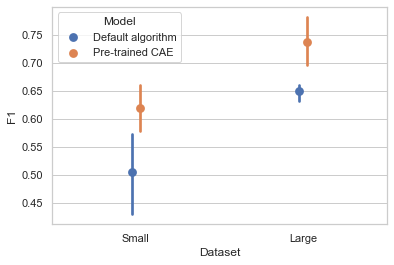

In [23]:
# Figure 7
sns.set_theme(style="whitegrid")
ax = sns.pointplot(x="Dataset", y="F1", hue='Model',
                 data=df, dodge=True, size=20, join = False, markers = 'o')

ax.figure.savefig('../figures/fig8.png')